# Showcasing the results
1. Estimation performance
2. Hypothesis testing performance

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os
import admix

In [2]:
def estimate_rg(est, est_var):
    """
    Estimate the ratio of genetic correlation.
    est: (3, ) numpy array
    est_var (3, 3) variance-covariance matrix
    """
    x, y = est[0], est[1]
    rg = y / x
    # grad = [-y / x^2, 1 / x]
    grad = np.array([-y / (x ** 2), 1 / x])

    def quad_form(x, A):
        return np.dot(np.dot(x.T, A), x)

    return rg, quad_form(grad, est_var[0:2, 0:2])

# Plot GCTA

In [3]:
import scipy

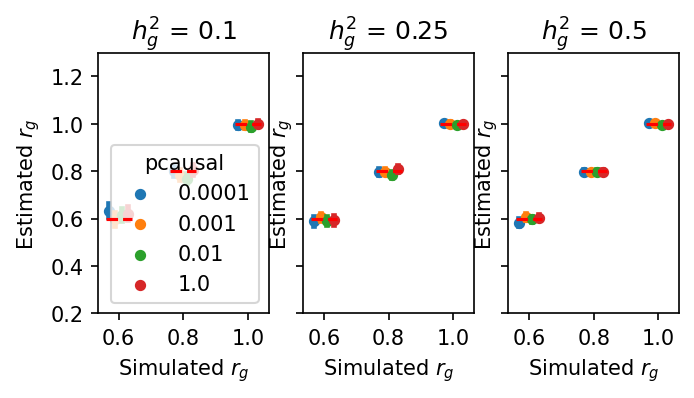

In [3]:
df_plot = []

for hsq in [0.1, 0.25, 0.5]:
    for pcausal in [0.0001, 0.001, 0.01, 1.0]:
        for cor in [0.6, 0.8, 1.0]:
            for hermodel in ["mafukb"]:
                for sim_i in range(100):
                    f_name = (
                        f"out/gcta-estimate/hsq-{hsq}-pcausal-{pcausal}-cor-{cor}"
                        + f"-hermodel-{hermodel}.sim_{sim_i}"
                    )
                    if not os.path.exists(f_name + ".hsq"):
                        continue
                    est = admix.tools.gcta.read_reml(f_name)
                    rg, rg_var = estimate_rg(
                        est["est"].Variance.values, est["varcov"].values
                    )
                    rg_stderr = np.sqrt(rg_var)
                    df_plot.append(
                        est["est"].Variance.values.tolist()
                        + [hsq, cor, pcausal, hermodel, rg, rg_stderr, sim_i]
                    )
df_plot = pd.DataFrame(
    df_plot,
    columns=[
        "estimated_var_g",
        "estimated_rho",
        "estimated_var_e",
        "hsq",
        "cor",
        "pcausal",
        "hermodel",
        "estimated_ratio",
        "estimated_ratio_stderr",
        "sim_i",
    ],
)

df_plot = df_plot[df_plot.estimated_ratio_stderr < 0.3]
fig, axes = plt.subplots(figsize=(5, 2.3), dpi=150, sharex=True, sharey=True, ncols=3)

for ax_i, hsq in enumerate([0.1, 0.25, 0.5]):
    df_tmp = df_plot[(df_plot.hsq == hsq)].copy()

    ax = axes[ax_i]

    sns.pointplot(
        data=df_tmp,
        x="cor",
        y="estimated_ratio",
        hue="pcausal",
        ax=ax,
        markers=".",
        dodge=0.3,
        join=False,
    )
    cor_list = sorted(df_plot.cor.unique())

    ax.hlines(
        cor_list,
        np.arange(len(cor_list)) - 0.2,
        np.arange(len(cor_list)) + 0.2,
        color="red",
        ls="--",
        zorder=10,
    )
    ax.set_ylim(0.2, 1.3)
    ax.set_xlabel("Simulated $r_g$")
    ax.set_ylabel("Estimated $r_g$")
    ax.set_title("$h_g^2$" + f" = {hsq}")
    if ax_i != 0:
        axes[ax_i].legend([], [], frameon=False)

In [ ]:
df_summary = (
    df_plot.groupby(["hsq", "cor", "pcausal"])
    .agg({"estimated_ratio": ["mean", "sem"]})["estimated_ratio"]
    .reset_index()
)
df_summary["pval"] = scipy.stats.norm.cdf(
    (df_summary["mean"] - df_summary["cor"]) / df_summary["sem"]
)

In [4]:
df_plot.groupby(["hsq", "cor", "pcausal"]).apply(lambda x: len(x["estimated_ratio"]))

hsq   cor  pcausal
0.10  0.6  0.0001      83
           0.0010      91
           0.0100      87
           1.0000      82
      0.8  0.0001      96
           0.0010      99
           0.0100      96
           1.0000      94
      1.0  0.0001      96
           0.0010      99
           0.0100      99
           1.0000      98
0.25  0.6  0.0001     100
           0.0010     100
           0.0100     100
           1.0000     100
      0.8  0.0001      98
           0.0010      98
           0.0100     100
           1.0000      99
      1.0  0.0001      97
           0.0010     100
           0.0100     100
           1.0000     100
0.50  0.6  0.0001      99
           0.0010     100
           0.0100      99
           1.0000     100
      0.8  0.0001      98
           0.0010      99
           0.0100     100
           1.0000      96
      1.0  0.0001      67
           0.0010     100
           0.0100      98
           1.0000      98
dtype: int64

In [5]:
rg_hat_std = df_plot.groupby(["hsq", "cor", "pcausal"]).apply(
    lambda x: np.std(x["estimated_ratio"])
)
mean_rg_std_hat = df_plot.groupby(["hsq", "cor", "pcausal"]).apply(
    lambda x: np.mean(x["estimated_ratio_stderr"])
)
df_plot = pd.DataFrame({"rg_hat_std": rg_hat_std, "mean_rg_std_hat": mean_rg_std_hat})

Text(0, 0.5, 'Mean of estimated standard error')

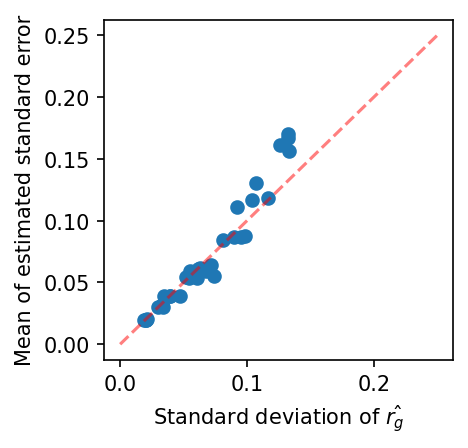

In [6]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(df_plot.rg_hat_std, df_plot.mean_rg_std_hat)
ax.plot([0, 0.25], [0, 0.25], "r--", alpha=0.5)
ax.set_xlabel("Standard deviation of $\hat{r_g}$")
ax.set_ylabel("Mean of estimated standard error")

# Plot likelihood ratio test

In [6]:
est["loglik"]

-8734.827

In [8]:
full_est

{'est':   Source  Variance        SE
 0  V(G1)  0.445093  0.097275
 1  V(G2)  0.439838  0.109384
 2   V(e)  0.903571  0.024088,
 'varcov':           V(G1)     V(G2)      V(e)
 V(G1)  0.009462  0.010439 -0.002091
 V(G2)  0.010439  0.011965 -0.002286
 V(e)  -0.002091 -0.002286  0.000580,
 'loglik': -8734.827,
 'n': 17299}

In [10]:
reduced_est

NameError: name 'reduced_est' is not defined

In [48]:
df_plot = []

for hsq in [0.25]:
    #     for pcausal in [0.0001, 0.001, 0.01, 1.0]:
    for pcausal in [1.0]:
        for cor in [0.8]:
            for hermodel in ["mafukb"]:
                for sim_i in range(100):
                    full_f_name = (
                        f"out/gcta-estimate/hsq-{hsq}-pcausal-{pcausal}-cor-{cor}"
                        + f"-hermodel-{hermodel}.sim_{sim_i}"
                    )
                    reduced_f_name = (
                        f"out/gcta-estimate/hsq-{hsq}-pcausal-{pcausal}-cor-{cor}"
                        + f"-hermodel-{hermodel}.sim_{sim_i}.reduced"
                    )
                    if not os.path.exists(full_f_name + ".hsq") or not os.path.exists(
                        reduced_f_name + ".hsq"
                    ):
                        continue
                    full_loglik = admix.tools.gcta.read_reml(full_f_name)["loglik"]
                    reduced_loglik = admix.tools.gcta.read_reml(reduced_f_name)[
                        "loglik"
                    ]
                    df_plot.append(
                        [
                            hsq,
                            cor,
                            pcausal,
                            hermodel,
                            full_loglik,
                            reduced_loglik,
                            sim_i,
                        ]
                    )
df_plot = pd.DataFrame(
    df_plot,
    columns=[
        "hsq",
        "cor",
        "pcausal",
        "hermodel",
        "full_loglik",
        "reduced_loglik",
        "sim_i",
    ],
)

# df_plot = df_plot[df_plot.estimated_ratio_stderr < 0.3]
# fig, axes = plt.subplots(figsize=(5, 2.3), dpi=150, sharex=True, sharey=True, ncols=3)

# for ax_i, hsq in enumerate([0.1, 0.25, 0.5]):
#     df_tmp = df_plot[(df_plot.hsq == hsq)].copy()

#     ax = axes[ax_i]

#     sns.pointplot(
#         data=df_tmp,
#         x="cor",
#         y="estimated_ratio",
#         hue="pcausal",
#         ax=ax,
#         markers=".",
#         dodge=0.3,
#         join=False,
#     )
#     cor_list = sorted(df_plot.cor.unique())

#     ax.hlines(
#         cor_list,
#         np.arange(len(cor_list)) - 0.2,
#         np.arange(len(cor_list)) + 0.2,
#         color="red",
#         ls="--",
#         zorder=10,
#     )
#     ax.set_ylim(0.2, 1.3)
#     ax.set_xlabel("Simulated $r_g$")
#     ax.set_ylabel("Estimated $r_g$")
#     ax.set_title("$h_g^2$" + f" = {hsq}")
#     if ax_i != 0:
#         axes[ax_i].legend([], [], frameon=False)

In [50]:
scipy.stats.kstest(
    2 * (df_plot["full_loglik"] - df_plot["reduced_loglik"]), scipy.stats.chi2(1).cdf
)

KstestResult(statistic=0.9815427665934405, pvalue=8.273521910658877e-174)

(array([ 2., 15., 13., 30., 19.,  7.,  6.,  5.,  1.,  2.]),
 array([ 0.973 ,  3.9604,  6.9478,  9.9352, 12.9226, 15.91  , 18.8974,
        21.8848, 24.8722, 27.8596, 30.847 ]),
 <BarContainer object of 10 artists>)

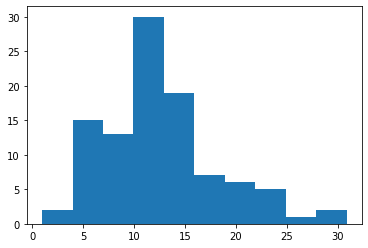

In [51]:
plt.hist(df_plot["full_loglik"] - df_plot["reduced_loglik"])

# Plot HE regression

In [ ]:
# rls_list = []

# for hsq in [0.1, 0.5]:
#     for pcausal in [0.01, 0.001, 1.0]:
#         for cor in [0.8, 1.0]:
#             for hermodel in ["mafukb"]:
#                 f_name = (
#                     f"out/estimate/hsq-{hsq}-pcausal-{pcausal}-cor-{cor}"
#                     + f"-hermodel-{hermodel}.estimate.json"
#                 )
#                 if not os.path.exists(f_name):
#                     continue
#                 with open(f_name) as f:
#                     data = json.load(f)

#                     df_tmp = pd.DataFrame(
#                         np.array([d["estimate"] for d in data]),
#                         columns=[
#                             "estimated_var_g",
#                             "estimated_rho",
#                             "estimated_var_e",
#                         ],
#                     )
#                     df_tmp["hsq"] = hsq
#                     df_tmp["cor"] = cor
#                     df_tmp["pcausal"] = pcausal
#                     df_tmp["hermodel"] = hermodel
#                     rls_list.append(df_tmp)

# df_plot = pd.concat(rls_list)
# df_plot["estimated_ratio"] = df_plot["estimated_rho"] / df_plot["estimated_var_g"]

# fig, axes = plt.subplots(figsize=(5, 2.3), dpi=150, sharex=True, sharey=True, ncols=2)

# for ax_i, hsq in enumerate([0.1, 0.5]):
#     df_tmp = df_plot[(df_plot.hsq == hsq)].copy()

#     ax = axes[ax_i]

#     sns.pointplot(
#         data=df_tmp,
#         x="cor",
#         y="estimated_ratio",
#         hue="pcausal",
#         ax=ax,
#         markers=".",
#         dodge=0.2,
#         join=False,
#     )
#     cor_list = sorted(df_plot.cor.unique())

#     ax.hlines(
#         cor_list,
#         np.arange(len(cor_list)) - 0.2,
#         np.arange(len(cor_list)) + 0.2,
#         color="red",
#         ls="--",
#         zorder=10,
#     )
#     ax.set_ylim(0.2, 1.3)
#     ax.set_xlabel("Simulated $r_g$")
#     ax.set_ylabel("Estimated $r_g$")
#     ax.set_title("$h_g^2$" + f" = {hsq}")
#     if ax_i != 0:
#         axes[ax_i].legend([], [], frameon=False)